## Setup

In [1]:
!pip uninstall torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y
!pip install torch==2.5.0+cu124 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install torch-geometric --no-cache-dir
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib --no-cache-dir --find-links https://data.pyg.org/whl/torch-2.5.0+cu124.html

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 861.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
     ━━

## Step 1: Data Loading & Preprocessing
Before training any model, it’s crucial to bring structure and consistency to the dataset. The following script:

- Loads the cleaned PrimeKG CSV file,

- Applies Unicode normalization to ensure consistent formatting across biomedical terms,

- Maps the diverse node types (e.g., "gene/protein", "chemical/drug") to standardized categories.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import unicodedata
import networkx as nx
import numpy as np
from torch_geometric.utils import from_networkx
from torch_geometric.data import HeteroData
from torch_geometric.nn import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Data
df = pd.read_csv("/content/drive/MyDrive/filtered_primekg.csv",
                 dtype={"x_name": str, "y_name": str, "relation": str, "x_type": str, "y_type": str},
                 low_memory=False)

print(f"[INFO] Data Loaded: {df.shape[0]} rows")

# Normalize Text Formatting
def clean_text(text):
    return unicodedata.normalize("NFKD", str(text)).strip().lower()

df["x_name"] = df["x_name"].apply(clean_text)
df["y_name"] = df["y_name"].apply(clean_text)

# Fix Node Type Mapping
node_type_mapping = {
    "gene/protein": "protein",
    "chemical/drug": "drug",
    "drug": "drug",
    "disease": "disease",
    "biological_process": "bioprocess",
    "bioprocess": "bioprocess",
    "pathway": "pathway",
    "effect/phenotype": "phenotype"
}

df["x_type"] = df["x_type"].map(node_type_mapping)
df["y_type"] = df["y_type"].map(node_type_mapping)

# Print Unique Relationships and Their Counts
print("\n [INFO] Relationship Counts:")
relation_counts = df["relation"].value_counts()
for relation, count in relation_counts.items():
    print(f"   {relation}: {count} edges")

[INFO] Data Loaded: 1803896 rows

 [INFO] Relationship Counts:
   protein_protein: 642150 edges
   disease_phenotype_positive: 300634 edges
   bioprocess_protein: 289610 edges
   disease_protein: 160822 edges
   drug_effect: 129568 edges
   pathway_protein: 85292 edges
   disease_disease: 64388 edges
   contraindication: 61350 edges
   drug_protein: 51306 edges
   indication: 18776 edges


## Extract Unique Node Names and Normalize Relation Types
In this step,  the biomedical graph is structured by:

Creating a Global Node Map:
We extract all unique node names (from both x_name and y_name columns) and assign each a global index using node_maps. This ensures that every entity in the graph (regardless of type) is embedded into a shared space — required for graph learning algorithms.

Constructing a Normalized Relation Map:
We iterate over all relation types in the dataset and:

Extract the type of source and target nodes for each relation.

Normalize the relation direction by sorting the (x_type, y_type) pairs alphabetically.

This helps in collapsing directional redundancy (e.g., treating "drug-disease" same as "disease-drug" for symmetric relations).

In [2]:
# ---- Extract Unique Node Names ----
all_nodes = pd.concat([df["x_name"], df["y_name"]]).dropna().unique()
node_maps = {name: i for i, name in enumerate(sorted(all_nodes))}
print(f"[INFO] Total unique nodes: {len(node_maps):,}")

# ---- Construct Normalized Relation Map ----
relation_map = {}

for rel in df["relation"].unique():
    subset = df[df["relation"] == rel]
    if subset.empty:
        continue

    type_pairs = set(zip(subset["x_type"], subset["y_type"]))

    for x_type, y_type in type_pairs:
        if x_type in node_type_mapping.values() and y_type in node_type_mapping.values():
            normalized_pair = tuple(sorted([x_type, y_type]))
            relation_map[rel] = normalized_pair

print(f"[INFO] Total unique normalized relations: {len(relation_map):,}")


[INFO] Total unique nodes: 68,284
[INFO] Total unique normalized relations: 10


## Step 3: Constructing the Undirected Graph
Building the Graph with Global Node Indices
In this step, I have constructed an undirected graph G using NetworkX, where each node is represented by its global index from the previously defined node_maps.

Here's what happens:

Iterate through each relation:
For every unique relation in relation_map, we extract the corresponding subset of edges from the DataFrame.

Map node names to indices:
Using the global node_maps, we convert x_name and y_name columns into numerical node indices. If a node name is missing (not found in node_maps), it's marked as -1.

Filter valid edges:
Edges where either node index is -1 are discarded. Only valid (source, target) pairs are added to the graph.

Add edges to the graph:
The valid edges are added to a NetworkX undirected graph, resulting in a graph that captures all biomedical entity relationships across the dataset.


In [3]:
# ---- Build Graph with Global Node Map ----
G = nx.Graph()

for rel in relation_map:
    rel_df = df[df['relation'] == rel]
    src_indices = rel_df['x_name'].map(node_maps).fillna(-1).astype(int)
    dst_indices = rel_df['y_name'].map(node_maps).fillna(-1).astype(int)

    valid_edges = [(s, d) for s, d in zip(src_indices, dst_indices) if s != -1 and d != -1]
    G.add_edges_from(valid_edges)

print("\n[INFO] Graph constructed successfully with global node map.")



[INFO] Graph constructed successfully with global node map.


##Mapping Node Metadata to Global Indices
This step builds a clean and structured DataFrame (node_df) that links each biomedical entity name to its type and its corresponding global index from the node_maps.

Step-by-Step:
Combine source and target nodes:
I have extracted node name/type pairs from both the x_* and y_* columns and merge them into a single DataFrame with uniform column names (node_name, node_type).

Remove duplicates and missing values:
To ensure a unique list of nodes,  drop any rows with missing values and eliminate duplicates.

Assign global indices:
Each node_name is mapped to its corresponding integer index from node_maps, resulting in a new column global_id.

This DataFrame is now the canonical reference for all node-level metadata — useful for plotting, negative sampling, and model input preparation.

In [4]:
# Step 1: Create a DataFrame with node_name, node_type, and global_id
node_df = pd.concat([
    df[["x_name", "x_type"]].rename(columns={"x_name": "node_name", "x_type": "node_type"}),
    df[["y_name", "y_type"]].rename(columns={"y_name": "node_name", "y_type": "node_type"})
]).dropna().drop_duplicates().reset_index(drop=True)

# Step 2: Add global ID from node_maps
node_df["global_id"] = node_df["node_name"].map(node_maps)


### Raw Node Distribution (Before Embedding)

Before diving into Node2Vec, it's important to understand the starting point. The plot below shows a random scatter of all nodes in the graph, colored by their type (e.g., protein, drug, disease, etc.). Since these coordinates are untrained and purely random, there’s no structure yet — all node types are chaotically mixed.

This baseline helps contrast what happens **after** we apply Node2Vec, where the learned embeddings reveal meaningful groupings, semantic patterns, and structural clusters.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_initial_node_distribution(node_df, dim=2, seed=42):
    """
    Simulates initial random node distribution colored by node type.
    Expects a DataFrame with columns: node_name, node_type
    """
    np.random.seed(seed)

    all_data = []
    for node_type, group in node_df.groupby("node_type"):
        coords = np.random.rand(len(group), dim)
        df = pd.DataFrame(
            coords,
            columns=["x", "y"] if dim == 2 else [f"dim_{i}" for i in range(dim)]
        )
        df["node_type"] = node_type
        df["node_name"] = group["node_name"].values  # Preserve identity
        all_data.append(df)

    full_df = pd.concat(all_data, ignore_index=True)

    if dim == 2:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=full_df,
            x="x", y="y",
            hue="node_type",
            palette="Set2",
            s=35,
            alpha=0.9,
            edgecolor=None
        )
        plt.title("Initial Node Distribution (Random 2D)")
        plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()
    else:
        print("[INFO] Higher-dimensional visualization not supported in 2D scatter.")



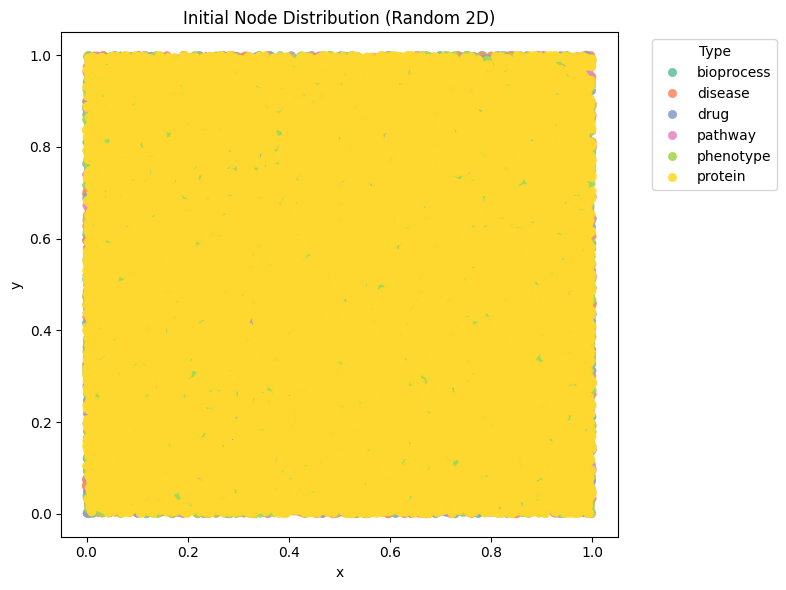

In [25]:
visualize_initial_node_distribution(node_df, dim=2, seed=42)

## Training Node2Vec embeddings

# Step 4: Training Node2Vec Embeddings with Edge Sampling
After constructing the biomedical graph, the next goal is to learn low-dimensional embeddings that preserve both structural and semantic similarity between entities. This is done using Node2Vec, a method that captures node neighborhoods via biased random walks.

What does this code do?

# Graph Conversion:
The NetworkX graph is converted to a PyTorch Geometric (PyG) format using from_networkx(), and transferred to GPU (if available).

Node2Vec Setup:

A Node2Vec model is initialized with:

- 128-dimensional embeddings

- Biased random walks of length 10

- Context window of size 5

- 20 walks per node

- 1 negative sample per training example

Training Strategy:

- Randomly sample edges and corresponding nodes.

- Generate positive and negative random walks.

- Use contrastive loss: make positive walks closer and negatives farther.

- Monitor validation loss and apply early stopping (patience = 200).




In [6]:
import torch
import numpy as np
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec
from sklearn.model_selection import train_test_split

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Convert NetworkX Graph to PyG format ---
pyg_graph = from_networkx(G)
pyg_graph.edge_index = pyg_graph.edge_index.to(device)

# --- Initialize Node2Vec ---
node2vec = Node2Vec(
    edge_index=pyg_graph.edge_index,
    embedding_dim=128,
    walk_length=10,
    context_size=5,
    walks_per_node=20,
    num_negative_samples=1
).to(device)

# Make sure necessary attributes are on the correct device
node2vec.rowptr = node2vec.rowptr.to(device)
node2vec.col = node2vec.col.to(device)

# --- Hyperparameters ---
batch_size = 256
patience = 200
epochs_no_improve = 0
best_loss = float("inf")

# --- Prepare Edge Splits for Evaluation ---
edge_index = pyg_graph.edge_index
num_edges = edge_index.size(1)
train_indices, val_indices = train_test_split(np.arange(num_edges), test_size=0.1, random_state=42)

train_indices = torch.tensor(train_indices, device=device)
val_indices = torch.tensor(val_indices, device=device)

optimizer = torch.optim.Adam(node2vec.parameters(), lr=0.0025)

print("[INFO] Starting Node2Vec training with edge sampling...")

# --- Training Loop ---
for epoch in range(1, 10001):
    optimizer.zero_grad()

    batch_idx = train_indices[torch.randint(0, train_indices.size(0), (batch_size,), device=device)]
    batch_nodes = edge_index[:, batch_idx].reshape(-1).unique()

    pos_rw = node2vec.pos_sample(batch_nodes)
    neg_rw = node2vec.neg_sample(batch_nodes)

    loss = node2vec.loss(pos_rw, neg_rw)
    loss.backward()
    optimizer.step()

    # --- Validation ---
    node2vec.eval()
    with torch.no_grad():
        val_batch_idx = val_indices[torch.randint(0, val_indices.size(0), (batch_size,), device=device)]
        val_batch_nodes = edge_index[:, val_batch_idx].reshape(-1).unique()

        val_pos_rw = node2vec.pos_sample(val_batch_nodes)
        val_neg_rw = node2vec.neg_sample(val_batch_nodes)
        val_loss = node2vec.loss(val_pos_rw, val_neg_rw)

    print(f"Epoch {epoch:04d}: Train Loss = {loss.item():.4f} | Val Loss = {val_loss.item():.4f}")

    # --- Early Stopping ---
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        torch.save(node2vec.embedding.weight.data.clone().cpu(), "best_node2vec_embeddings.pt")
        print(f"[INFO]  New Best Loss: {best_loss:.4f} → Saved embeddings.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"[INFO]  Early stopping after {epoch} epochs.")
        break

print("\n[INFO] Node2Vec embedding training completed successfully!")


Streaming output truncated to the last 5000 lines.
Epoch 1888: Train Loss = 1.6325 | Val Loss = 1.6207
[INFO]  New Best Loss: 1.6207 → Saved embeddings.
Epoch 1889: Train Loss = 1.6333 | Val Loss = 1.6345
Epoch 1890: Train Loss = 1.6330 | Val Loss = 1.6282
Epoch 1891: Train Loss = 1.6255 | Val Loss = 1.6225
Epoch 1892: Train Loss = 1.6438 | Val Loss = 1.6297
Epoch 1893: Train Loss = 1.6240 | Val Loss = 1.6246
Epoch 1894: Train Loss = 1.6282 | Val Loss = 1.6262
Epoch 1895: Train Loss = 1.6168 | Val Loss = 1.6238
Epoch 1896: Train Loss = 1.6303 | Val Loss = 1.6177
[INFO]  New Best Loss: 1.6177 → Saved embeddings.
Epoch 1897: Train Loss = 1.6273 | Val Loss = 1.6185
Epoch 1898: Train Loss = 1.6170 | Val Loss = 1.6249
Epoch 1899: Train Loss = 1.6185 | Val Loss = 1.6287
Epoch 1900: Train Loss = 1.6092 | Val Loss = 1.6163
[INFO]  New Best Loss: 1.6163 → Saved embeddings.
Epoch 1901: Train Loss = 1.6202 | Val Loss = 1.6279
Epoch 1902: Train Loss = 1.6155 | Val Loss = 1.6231
Epoch 1903: Train L

## Step 5:Disease-Phenotype Link Prediction using Logistic Regression

Once the Node2Vec embeddings are trained, the next task is to predict potential links in the graph — specifically, between diseases and phenotypes, or any other entity types.

This is achieved using a Logistic Regression model trained on edge features derived from node embeddings.

What does the code do?

- Positive Samples:
All existing edges of a given relation (e.g., "disease_phenotype_positive") are collected as positive training examples.

- Negative Sampling:
Randomly sampled node pairs (that don’t form a real edge) are used as negative examples, ensuring the model learns to differentiate between real and fake links.

- Feature Construction:
For each node pair:

Multiply embeddings (u * v) and sum across dimensions to get a single similarity score per edge.

These scores form the feature matrix X.

 Model Training:

- Logistic Regression is trained using a train_test_split.

- class_weight="balanced" ensures the model is robust to imbalanced classes.

- Evaluation:

Key metrics include:Accuracy, Precision, Recall, F1 Score, ROC-AUC for probabilistic discrimination

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import random


embeddings = torch.load("best_node2vec_embeddings.pt").to(device)

def evaluate_link_prediction(relation_name, src_type, tgt_type, node1_name, node2_name, top_k=10):
    print(f"\n[INFO] Evaluating {src_type.title()} ↔ {tgt_type.title()} for relation: {relation_name}")

    # Step 1: Get positive edges for the relation
    relation_edges = np.sort(
        df[df["relation"] == relation_name][["x_name", "y_name"]].values.astype("U"),
        axis=1
    )
    relation_edges = np.unique(relation_edges, axis=0)

    # Step 2: Get valid node lists for each type
    src_nodes = list(node_df[node_df["node_type"] == src_type]["node_name"])
    tgt_nodes = list(node_df[node_df["node_type"] == tgt_type]["node_name"])

    # Step 3: Create positive edge index pairs
    pos_edges = np.array([
        [node_maps[x], node_maps[y]]
        for x, y in relation_edges
        if x in node_maps and y in node_maps
    ])

    if len(pos_edges) == 0:
        print("[ERROR] No valid positive edges found. Check relation or node types.")
        return

    # Step 4: Sample negatives once, of the same size
    num_samples = len(pos_edges)
    neg_edges = np.array([
        [node_maps[random.choice(src_nodes)], node_maps[random.choice(tgt_nodes)]]
        for _ in range(num_samples)
    ])

    # Step 5: Split positives and negatives into train/test separately
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)

    # Step 6: Compute features using dot product (u · v)
    def edge_features(edges):
        return (embeddings[edges[:, 0]] * embeddings[edges[:, 1]]).sum(dim=1).view(-1, 1)

    X_train = torch.cat([edge_features(pos_train), edge_features(neg_train)], dim=0).cpu().numpy()

    y_train = np.array([1] * len(pos_train) + [0] * len(neg_train))

    X_test = torch.cat([edge_features(pos_test), edge_features(neg_test)], dim=0).cpu().numpy()
    y_test = np.array([1] * len(pos_test) + [0] * len(neg_test))

    # Step 7: Train logistic regression
    model = LogisticRegression(class_weight="balanced", max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    # Step 8: Evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)

    print("\n[INFO] Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Step 9: Top-k highest scoring negative edges (for inspection)
    print(f"\n[INFO] Top-{top_k} Predicted {src_type.title()} ↔ {tgt_type.title()} Links:")
    top_indices = np.argsort(probs)[-top_k:]
    test_neg_only = neg_test[:len(probs)]  # safeguard
    for idx in top_indices:
        if idx < len(test_neg_only):
            u_idx, v_idx = test_neg_only[idx]
            u_name = next((k for k, v in node_maps.items() if v == u_idx), "UNKNOWN")
            v_name = next((k for k, v in node_maps.items() if v == v_idx), "UNKNOWN")
            print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

    # Step 10: Score user-defined node pair
    print(f"\nScoring: \"{node1_name}\" ↔ \"{node2_name}\"")
    if node1_name in node_maps and node2_name in node_maps:
        u = node_maps[node1_name]
        v = node_maps[node2_name]
        pair_feat = (embeddings[u] * embeddings[v]).sum().item()
        pair_score = model.predict_proba(np.array([[pair_feat]]))[:, 1][0]
        print(f"Predicted probability: {pair_score:.4f}")
    else:
        print("One or both nodes not found in node maps.")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }



<ipython-input-13-a29ca1ce357d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("best_node2vec_embeddings.pt").to(device)


In [14]:
evaluate_link_prediction(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)



[INFO] Evaluating Disease ↔ Phenotype for relation: disease_phenotype_positive

[INFO] Evaluation Metrics:
Accuracy:  0.5009
Precision: 0.5010
Recall:    0.4442
F1 Score:  0.4709
ROC-AUC:   0.5032

[INFO] Top-10 Predicted Disease ↔ Phenotype Links:
papillary meningioma of the cerebellum ↔ hypoactive bowel sounds (score: 0.5374)
legionellosis ↔ demyelinating motor neuropathy (score: 0.5406)
infection by trypanosoma gambiense ↔ lichenoid skin lesion (score: 0.5420)
subaortic stenosis ↔ abnormal parotid gland morphology (score: 0.5436)
histoplasmosis retinitis ↔ short metacarpal (score: 0.5533)
hypertensive retinopathy ↔ electronegative electroretinogram (score: 0.5535)

Scoring: "permanent neonatal diabetes mellitus" ↔ "retinopathy"
Predicted probability: 0.5027


{'accuracy': 0.5008981438360721,
 'precision': 0.5010130571814498,
 'recall': 0.4441820238174439,
 'f1_score': 0.47088902211094263,
 'roc_auc': np.float64(0.5031744376548728)}

## Step 6: Link Prediction with XGBoost
While Logistic Regression provides a baseline, XGBoost brings the power of gradient boosting to this task — often yielding stronger performance on structured graph data.


Positive and Negative Sampling:

- Real edges (positive) are sampled from a target biomedical relation (e.g., disease-phenotype).

- Random fake edges (negative) are generated via node sampling.

Feature Engineering:

- Instead of dot product, embedding concatenation is used to retain rich relational structure.

- Positive and negative edge features are combined to form a full dataset X.

Model Training:

An XGBClassifier is trained with:

- n_estimators=200

- max_depth=5

- learning_rate=0.05

Tuned for stability with subsampling and colsampling.

Evaluation:

Predictions and probabilities are evaluated using:

Accuracy, Precision, Recall, F1 Score

ROC-AUC

In [17]:
import random
import numpy as np
import torch
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

def evaluate_with_xgboost(relation_name, src_type, tgt_type, node1_name, node2_name, top_k=10):
    print(f"\n[INFO] Evaluating {src_type.title()} ↔ {tgt_type.title()} with XGBoost for relation: {relation_name}")

    # Step 1: Get positive edges for the relation
    relation_edges = np.sort(
        df[df["relation"] == relation_name][["x_name", "y_name"]].values.astype("U"),
        axis=1
    )
    relation_edges = np.unique(relation_edges, axis=0)

    # Step 2: Get node names for the types
    src_nodes = list(node_df[node_df["node_type"] == src_type]["node_name"])
    tgt_nodes = list(node_df[node_df["node_type"] == tgt_type]["node_name"])

    # Step 3: Construct valid positive edge index pairs
    pos_edges = np.array([
        [node_maps[x], node_maps[y]]
        for x, y in relation_edges
        if x in node_maps and y in node_maps
    ])

    if len(pos_edges) == 0:
        print("[ERROR] No valid positive edges found.")
        return

    # Step 4: Sample negatives once, same size as positives
    num_samples = len(pos_edges)
    neg_edges = np.array([
        [node_maps[random.choice(src_nodes)], node_maps[random.choice(tgt_nodes)]]
        for _ in range(num_samples)
    ])

    # Step 5: Split pos/neg edges into train/test
    pos_train, pos_test = train_test_split(pos_edges, test_size=0.2, random_state=42)
    neg_train, neg_test = train_test_split(neg_edges, test_size=0.2, random_state=42)

    # Step 6: Define embedding concatenation
    def concat_features(edge_array):
        return torch.cat([
            embeddings[edge_array[:, 0]],
            embeddings[edge_array[:, 1]]
        ], dim=1)

    X_train = torch.cat([concat_features(pos_train), concat_features(neg_train)], dim=0).cpu().numpy()
    y_train = np.array([1] * len(pos_train) + [0] * len(neg_train))

    X_test = torch.cat([concat_features(pos_test), concat_features(neg_test)], dim=0).cpu().numpy()
    y_test = np.array([1] * len(pos_test) + [0] * len(neg_test))

    # Step 7: Train XGBoost model
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0
    )
    model.fit(X_train, y_train)

    # Step 8: Evaluate
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)

    print("\n[INFO] XGBoost Prediction Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Step 9: Score a specific user-defined pair
    print(f"\nScoring: \"{node1_name}\" ↔ \"{node2_name}\"")
    if node1_name in node_maps and node2_name in node_maps:
        u = node_maps[node1_name]
        v = node_maps[node2_name]
        pair_feat = torch.cat([embeddings[u], embeddings[v]]).cpu().numpy().reshape(1, -1)
        score = model.predict_proba(pair_feat)[:, 1][0]
        print(f"Predicted probability: {score:.4f}")
    else:
        print("One or both nodes not found in node mappings.")

    # Step 10: Show top-k predicted negative links
    print(f"\nSample Predicted {src_type.title()} ↔ {tgt_type.title()} Links (XGBoost):")
    top_indices = np.argsort(probs)[-top_k:]
    test_neg_only = neg_test[:len(probs)]  # safeguard
    for idx in top_indices:
        if idx < len(test_neg_only):
            u_idx, v_idx = test_neg_only[idx]
            u_name = next((k for k, v in node_maps.items() if v == u_idx), "UNKNOWN")
            v_name = next((k for k, v in node_maps.items() if v == v_idx), "UNKNOWN")
            print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
    }


In [18]:
evaluate_with_xgboost(
    relation_name="disease_phenotype_positive",
    src_type="disease",
    tgt_type="phenotype",
    node1_name="permanent neonatal diabetes mellitus",
    node2_name="retinopathy"
)



[INFO] Evaluating Disease ↔ Phenotype with XGBoost for relation: disease_phenotype_positive

[INFO] XGBoost Prediction Metrics:
Accuracy:  0.8018
Precision: 0.8040
Recall:    0.7983
F1 Score:  0.8011
ROC-AUC:   0.8880

Scoring: "permanent neonatal diabetes mellitus" ↔ "retinopathy"
Predicted probability: 0.4467

Sample Predicted Disease ↔ Phenotype Links (XGBoost):
writing disorder ↔ onychogryposis (score: 0.9828)
hepatocellular carcinoma ↔ abdominal cramps (score: 0.9829)
complex spastic paraplegia ↔ horizontal sacrum (score: 0.9830)
primary myelofibrosis ↔ ambiguous genitalia, male (score: 0.9840)
aorta atresia ↔ insulin receptor antibody positivity (score: 0.9844)
polyneuropathy associated with igm monoclonal gammapathy with anti-mag ↔ partially duplicated kidney (score: 0.9846)
desulfovibrionaceae infectious disease ↔ saccular conjunctival dilatations (score: 0.9847)
anosmia (disease) ↔ abnormality of skin pigmentation (score: 0.9854)
neurodevelopmental disorder with microcephaly,

{'accuracy': 0.8018095935067527,
 'precision': 0.8039530988274707,
 'recall': 0.7982835473355067,
 'f1_score': 0.8011082921618373,
 'roc_auc': np.float64(0.8880293851138003)}

## Step 7: Visualizing Learned Representations and Predictions
Once the Node2Vec embeddings are trained, several visualizations help make sense of the learned structure:

- Embedding Projection with t-SNE or PCA
To see how well the node embeddings capture structural or semantic distinctions, dimensionality reduction techniques like t-SNE or PCA are applied:

- t-SNE groups similar node types together based on their learned features.

Interpretation: Nodes with similar roles or relationships in the biomedical graph tend to cluster together in the embedding space.

- Top-K Predicted Links from ML Models
Using trained models like Logistic Regression or XGBoost, one can inspect the most confident predictions:


This lists top predicted edges between unconnected nodes.

Useful for identifying potential missing links in the knowledge graph.

- Cosine Similarity Heatmap of Selected Nodes
To explore relationships between specific biomedical entities, a cosine similarity heatmap can be plotted:

Helps quantify how semantically close diseases (or any node type) are in the embedding space.




In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 4. t-SNE or PCA Projection of Embeddings (Improved Color Palette)
def plot_embedding_projection(embeddings, labels, method="tsne", title="Embedding Projection"):
    """
    Projects node embeddings into 2D space using t-SNE or PCA and visualizes them with enhanced colors.

    Parameters:
    - embeddings: numpy array or torch.Tensor
    - labels: list of categorical labels (e.g., node types)
    - method: 'tsne' or 'pca'
    - title: plot title
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Choose method as 'tsne' or 'pca'")

    if hasattr(embeddings, "cpu"):  # For torch.Tensor
        embeddings = embeddings.cpu().detach().numpy()

    reduced = reducer.fit_transform(embeddings)
    df = pd.DataFrame(reduced, columns=["x", "y"])
    df["label"] = labels

    plt.figure(figsize=(9, 7))
    pastel_palette = sns.color_palette("Set2")  # Better for categorical groups

    sns.scatterplot(
        data=df, x="x", y="y", hue="label",
        palette=pastel_palette, s=40, alpha=0.85, edgecolor="white", linewidth=0.4
    )

    plt.xlabel("Component 1", fontsize=12)
    plt.ylabel("Component 2", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(title="Node Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# 5. Top-k Predicted Links

def show_topk_predicted_links(model, embeddings, node_maps, neg_edges, top_k=10):
    """
    Shows top-k highest scoring negative edges predicted as positive links.
    Assumes `node_maps` is flat: {node_name: global_index}
    """

    probs = model.predict_proba(
        torch.cat([
            embeddings[neg_edges[:, 0]],
            embeddings[neg_edges[:, 1]]
        ], dim=1).numpy()
    )[:, 1]

    top_indices = np.argsort(probs)[-top_k:]
    print(f"\nTop-{top_k} Predicted Links:")
    for idx in top_indices:
        u, v = neg_edges[idx]

        u_name = next((k for k, val in node_maps.items() if val == u), "UNKNOWN")
        v_name = next((k for k, val in node_maps.items() if val == v), "UNKNOWN")

        print(f"{u_name} ↔ {v_name} (score: {probs[idx]:.4f})")

def plot_similarity_heatmap(embeddings, selected_nodes, node_maps, title="Cosine Similarity Heatmap"):
    """
    Plots a cosine similarity heatmap between selected nodes.
    Assumes `node_maps` is flat and contains node_name → global_index.
    """
    # Filter valid nodes that exist in node_maps
    valid_nodes = [n for n in selected_nodes if n in node_maps]
    missing_nodes = [n for n in selected_nodes if n not in node_maps]

    if missing_nodes:
        print(f"[WARNING] These nodes were skipped (not found in node_maps): {missing_nodes}")

    indices = [node_maps[n] for n in valid_nodes]
    selected_embeds = embeddings[indices]

    sim_matrix = torch.nn.functional.cosine_similarity(
        selected_embeds.unsqueeze(1), selected_embeds.unsqueeze(0), dim=2
    ).detach().numpy()

    df = pd.DataFrame(sim_matrix, index=valid_nodes, columns=valid_nodes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="viridis", square=True, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
<ipython-input-34-f255e6f99978>:32: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.scatterplot(


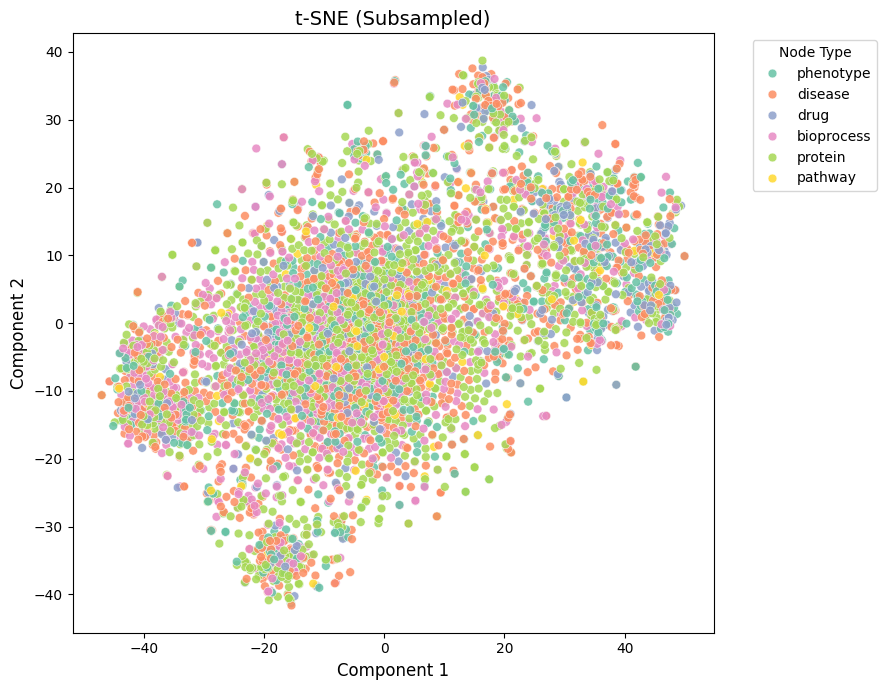

In [37]:
# Create a list of node types aligned with embedding indices
labels = [None] * embeddings.shape[0]
for _, row in node_df.iterrows():
    idx = row["global_id"]
    if 0 <= idx < len(labels):
        labels[idx] = row["node_type"]


max_samples = 5000
indices = np.random.choice(len(labels), size=min(max_samples, len(labels)), replace=False)
sampled_embeddings = embeddings[indices]
sampled_labels = [labels[i] for i in indices]

plot_embedding_projection(sampled_embeddings, sampled_labels, method="tsne", title="t-SNE (Subsampled)")

[WARNING] These nodes were skipped (not found in node_maps): ['diabetes', 'obesity']


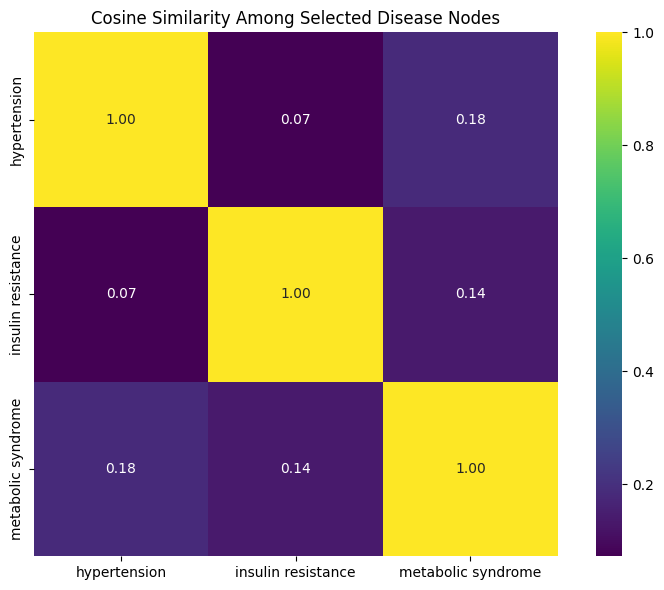

In [39]:
selected_nodes = [
    "diabetes",
    "hypertension",
    "insulin resistance",
    "metabolic syndrome",
    "obesity"
]

plot_similarity_heatmap(
    embeddings=embeddings,
    selected_nodes=selected_nodes,
    node_maps=node_maps,  # flat dict: {name → global_id}
    title="Cosine Similarity Among Selected Disease Nodes"
)
